In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import requests
import datetime
import time
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization,Conv1D,Flatten,MaxPooling1D,LSTM
from keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

plt.style.use('default')

In [2]:
market = 'BTC-GBP'
granularity = 3600

In [3]:
def getHistoricalData(market: str='BTC-GBP', granularity: int=3600, iso8601start: str='', iso8601end: str='') -> pd.DataFrame:
  if iso8601start != '' and iso8601end == '':
    resp = requests.get(f'https://api.pro.coinbase.com/products/{market}/candles?granularity={granularity}&start={iso8601start}')
  elif iso8601start != '' and iso8601end != '':
    resp = requests.get(f'https://api.pro.coinbase.com/products/{market}/candles?granularity={granularity}&start={iso8601start}&end={iso8601end}')
  else:
    resp = requests.get(f'https://api.pro.coinbase.com/products/{market}/candles?granularity={granularity}')

  df = pd.DataFrame.from_dict(resp.json())
  df.columns = [ 'epoch','low','high','open','close','volume' ]
  df['adj_close'] = df['close']

  tsidx = pd.DatetimeIndex(pd.to_datetime(df['epoch'], unit='s'), dtype='datetime64[ns]')
  df.set_index(tsidx, inplace=True)
  df = df.drop(columns=['epoch'])
  df.index.names = ['date']

  return df.iloc[::-1].reset_index()

In [4]:
def getHistoricalDataChained(market: str='BTC-GBP', granularity: int=3600, max_interations: int=1) -> pd.DataFrame:
  df1 = getHistoricalData(market, granularity)

  if max_interations == 1:
    return df1

  def getPreviousDateRange(df: pd.DataFrame=None) -> tuple:
    end_date = df['date'].min() - timedelta(seconds=(granularity / 60))
    new_start = df['date'].min() - timedelta(hours=300)
    return (str(new_start).replace(' ', 'T'), str(end_date).replace(' ', 'T'))

  iterations = 0
  result_df = pd.DataFrame()
  while iterations < (max_interations - 1):
    start_date, end_date = getPreviousDateRange(df1)
    df2 = getHistoricalData(market, granularity, start_date, end_date)
    result_df = pd.concat([df2, df1]).drop_duplicates()
    df1 = result_df
    iterations = iterations + 1

  if 'date'in result_df:
    result_df.sort_values(by=['date'], ascending=True, inplace=True)
        
  return result_df

In [76]:
df = getHistoricalDataChained(market, granularity, 30) # 1 year
df.shape

(8998, 7)

In [77]:
print (f'{df.shape[0] / 24} days of hourly trading data!')

374.9166666666667 days of hourly trading data!


In [78]:
df.head()

,date,low,high,open,close,volume,adj_close
0,2020-06-07 11:00:00,7578.00,7627.44,7622.32,7583.98,19.797435,7583.98
1,2020-06-07 12:00:00,7506.00,7606.68,7583.97,7536.40,87.580372,7536.40
2,2020-06-07 13:00:00,7474.51,7557.44,7533.51,7479.38,104.499495,7479.38
3,2020-06-07 14:00:00,7420.00,7530.00,7477.02,7491.72,114.134042,7491.72
4,2020-06-07 15:00:00,7486.32,7525.33,7490.09,7523.99,33.321972,7523.99


In [79]:
df['mv_avg_12'] = df['close'].rolling(window=12).mean().shift(1)
df['mv_avg_24'] = df['close'].rolling(window=24).mean().shift(1)
df.tail()

,date,low,high,open,close,volume,adj_close,mv_avg_12,mv_avg_24
295,2021-06-17 06:00:00,27667.08,28100.00,27680.70,28055.37,31.804767,28055.37,27644.490000,27806.214583
296,2021-06-17 07:00:00,27990.00,28200.00,28080.32,28077.52,55.949759,28077.52,27678.115833,27781.378750
297,2021-06-17 08:00:00,27970.01,28194.09,28075.25,28169.99,40.043449,28169.99,27714.810833,27765.790000
298,2021-06-17 09:00:00,28010.00,28412.58,28164.43,28286.58,46.207132,28286.58,27766.923333,27755.843750
299,2021-06-17 10:00:00,28211.81,28311.65,28282.05,28247.21,7.032297,28247.21,27813.800000,27753.663333


In [80]:
df['rapp'] = df['close'].shift(-1).divide(df['close'])
df['next_close'] = df['close'].shift(-1)
df.head()

,date,low,high,open,close,volume,adj_close,mv_avg_12,mv_avg_24,rapp,next_close
0,2020-06-07 11:00:00,7578.00,7627.44,7622.32,7583.98,19.797435,7583.98,NaN,NaN,0.993726,7536.40
1,2020-06-07 12:00:00,7506.00,7606.68,7583.97,7536.40,87.580372,7536.40,NaN,NaN,0.992434,7479.38
2,2020-06-07 13:00:00,7474.51,7557.44,7533.51,7479.38,104.499495,7479.38,NaN,NaN,1.001650,7491.72
3,2020-06-07 14:00:00,7420.00,7530.00,7477.02,7491.72,114.134042,7491.72,NaN,NaN,1.004307,7523.99
4,2020-06-07 15:00:00,7486.32,7525.33,7490.09,7523.99,33.321972,7523.99,NaN,NaN,0.999090,7517.14


In [81]:
df.index = df['date']
df.drop(columns=['date'], inplace=True)
df.head()

,low,high,open,close,volume,adj_close,mv_avg_12,mv_avg_24,rapp,next_close
date,,,,,,,,,,
2020-06-07 11:00:00,7578.00,7627.44,7622.32,7583.98,19.797435,7583.98,NaN,NaN,0.993726,7536.40
2020-06-07 12:00:00,7506.00,7606.68,7583.97,7536.40,87.580372,7536.40,NaN,NaN,0.992434,7479.38
2020-06-07 13:00:00,7474.51,7557.44,7533.51,7479.38,104.499495,7479.38,NaN,NaN,1.001650,7491.72
2020-06-07 14:00:00,7420.00,7530.00,7477.02,7491.72,114.134042,7491.72,NaN,NaN,1.004307,7523.99
2020-06-07 15:00:00,7486.32,7525.33,7490.09,7523.99,33.321972,7523.99,NaN,NaN,0.999090,7517.14


In [82]:
df.dropna(inplace=True)
df.tail()

,low,high,open,close,volume,adj_close,mv_avg_12,mv_avg_24,rapp,next_close
date,,,,,,,,,,
2021-06-17 05:00:00,27636.82,27781.15,27741.36,27698.07,14.258725,27698.07,27652.431667,27843.214583,1.012900,28055.37
2021-06-17 06:00:00,27667.08,28100.00,27680.70,28055.37,31.804767,28055.37,27644.490000,27806.214583,1.000790,28077.52
2021-06-17 07:00:00,27990.00,28200.00,28080.32,28077.52,55.949759,28077.52,27678.115833,27781.378750,1.003293,28169.99
2021-06-17 08:00:00,27970.01,28194.09,28075.25,28169.99,40.043449,28169.99,27714.810833,27765.790000,1.004139,28286.58
2021-06-17 09:00:00,28010.00,28412.58,28164.43,28286.58,46.207132,28286.58,27766.923333,27755.843750,0.998608,28247.21


In [83]:
mtest = round(len(df) * 0.3)
train = df.iloc[:-mtest,:]
test = df.iloc[-mtest:,:]
train.shape, test.shape

((6281, 10), (2692, 10))

In [84]:
def yield_gross(df, v):
  prod=(v*df["rapp"]+1-v).prod()
  n_days=len(v)/24
  return (prod-1)*100,((prod**(1/n_days))-1)*100

In [85]:
def create_window(data, window_size=1):    
  data_s = data.copy()
  for i in range(window_size):
    data = pd.concat([data, data_s.shift(-(i+1))], axis=1)
        
  data.dropna(axis=0, inplace=True)
  return data

In [102]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = pd.DataFrame(scaler.fit_transform(df[['low','high','open','close','volume','mv_avg_12','mv_avg_24','next_close']].values))
X_df_scaled = df_scaled[[0,1,2,3,4,5,6]]

In [105]:
window = 4
df_window = create_window(X_df_scaled, window)
X_df_window = np.reshape(df_window.values, (df_window.shape[0], window+1, len(X_df_scaled.columns)))
y_df_window = np.array(df_scaled[len(df_scaled.columns)-1][window:])

X_df_window.shape, y_df_window.shape

((8969, 5, 7), (8969,))

In [107]:
X_train = X_df_window[:-mtest-1,:,:]
X_test = X_df_window[-mtest-1:,:,:]
y_train = y_df_window[:-mtest-1]
y_test = y_df_window[-mtest-1:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6276, 5, 7), (2693, 5, 7), (6276,), (2693,))

In [110]:
def model_lstm(window,features):
  model = Sequential()
  model.add(LSTM(300, input_shape = (window, features), return_sequences=True))
  model.add(Dropout(0.5))
  model.add(LSTM(200, input_shape=(window, features), return_sequences=False))
  model.add(Dropout(0.5))
  model.add(Dense(100, kernel_initializer='uniform', activation='relu'))        
  model.add(Dense(1, kernel_initializer='uniform', activation='relu'))
  model.compile(loss='mse', optimizer='adam')
  return model

Epoch 1/100
262/262 [==============================] - 7s 11ms/step - loss: 1.6699e-04 - val_loss: 0.0397
Epoch 2/100
262/262 [==============================] - 2s 7ms/step - loss: 0.0151 - val_loss: 0.5565
Epoch 3/100
262/262 [==============================] - 2s 7ms/step - loss: 0.0098 - val_loss: 0.5565
Epoch 4/100
262/262 [==============================] - 2s 7ms/step - loss: 0.0098 - val_loss: 0.5565
Epoch 5/100
262/262 [==============================] - 2s 7ms/step - loss: 0.0098 - val_loss: 0.5565
Epoch 6/100
262/262 [==============================] - 2s 7ms/step - loss: 0.0098 - val_loss: 0.5565
Epoch 7/100
262/262 [==============================] - 2s 7ms/step - loss: 0.0098 - val_loss: 0.5565
Epoch 8/100
262/262 [==============================] - 2s 9ms/step - loss: 0.0098 - val_loss: 0.5565
Epoch 9/100
262/262 [==============================] - 2s 8ms/step - loss: 0.0098 - val_loss: 0.5565
Epoch 10/100
262/262 [==============================] - 2s 8ms/step - loss: 0.0098 - v

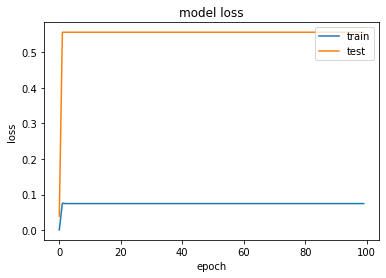

In [112]:
model = model_lstm(window+1, len(dg0.columns))

fit_log = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=24,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[],
    shuffle=False
    )

plt.plot(fit_log.history['loss'])
plt.plot(fit_log.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [113]:
y_pr = model.predict(X_train)

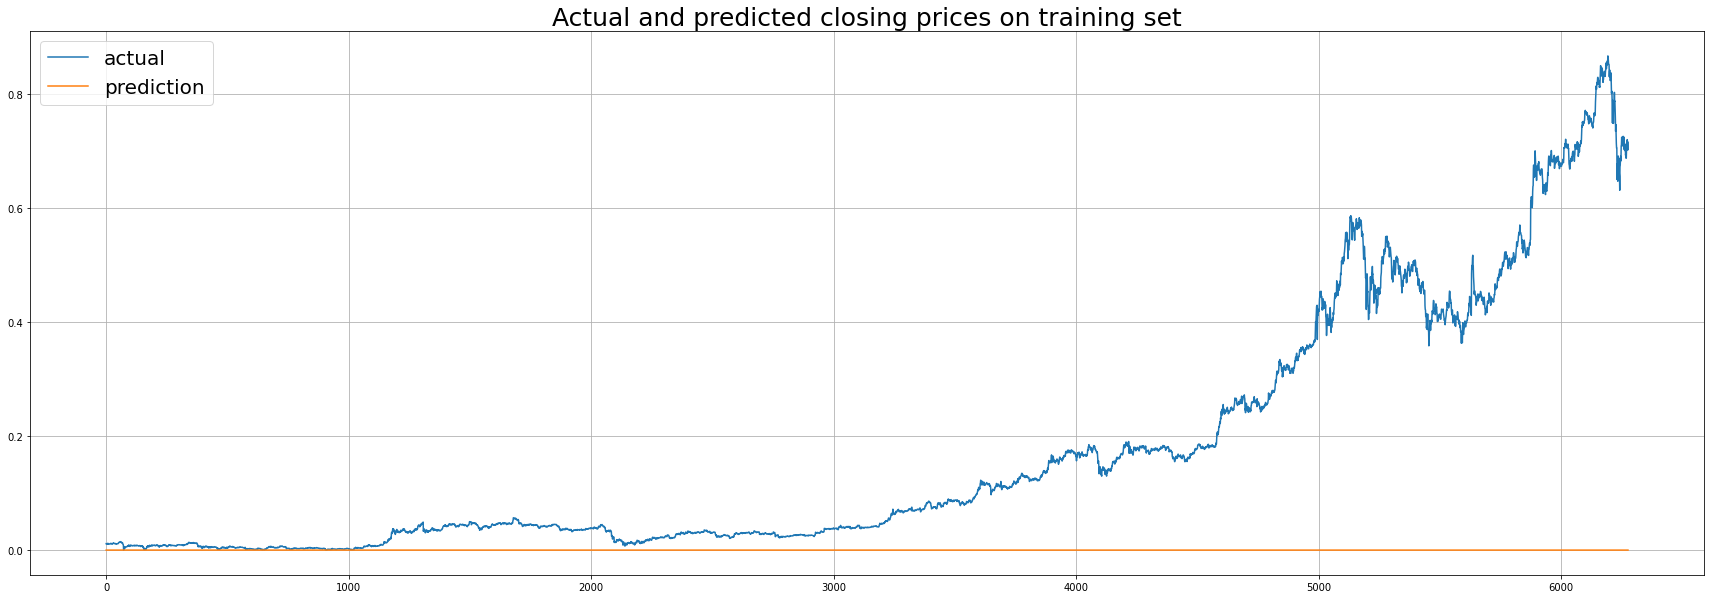

In [114]:
plt.figure(figsize=(30,10))
plt.plot(y_trainw, label='actual')
plt.plot(y_pr, label='prediction')
plt.legend(fontsize=20)
plt.grid(axis='both')
plt.title('Actual and predicted closing prices on training set', fontsize=25)
plt.show()